<h1>Compare cities</h1>

<h2> Compare and cluster international cities</h2>

It's not always easy to move in a new city for a job. I will try to build a city recommender. People will be able to choose a city and a neighborood, then a target city, and neighborhood with the closest features from their neighborhood will be proposed.

I will use the foursquare API in order to retrieve the features of the neighboroods.

For the aim of this project, I will only work with three cities: Paris, New York and Singapore, as there is limitations in the foursquare API.

<h2> First step: build a dataset of neighborhood coordinates for Paris, New York and Singapore</h2>

<i>I will first create a list of adresses in with each item with the following format: city, neighborood.</i> 

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
import matplotlib.pyplot as plt

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

import folium # plotting library
from sklearn.cluster import KMeans
from matplotlib import cm
from colormap import rgb2hex

from bs4 import BeautifulSoup
import urllib.request
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram


Bad key "text.kerning_factor" on line 4 in
C:\Users\legea\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
#Connect to foursquare
mylink="C:/Users/legea/Documents/003_IBM/"

foursq=pd.read_csv(mylink+"foursquare.txt",header=None,sep=':')

foursq.columns=['type',"key"]

CLIENT_ID = foursq[foursq.type=='ID']['key'].item() # your Foursquare ID
CLIENT_SECRET = foursq[foursq.type=='SECRET']['key'].item() # your Foursquare Secret
VERSION = '20180604'
LIMIT = 150

<b>1 - Paris</b>

In [3]:
#There is 20 districts in Paris. I will create their postcodes.
list_adress=[]
for i in range(1,21):
    list_adress.append('{},{}'.format('Paris','75'+str(i).zfill(3)))
    


In [4]:
list_adress[1:5]

['Paris,75002', 'Paris,75003', 'Paris,75004', 'Paris,75005']

<b>2 - Singapore </b>

In [5]:
#For Singapore, I will retrive data from wikipedia. Geocoder had problem to retrieve coordinates with the district number,
#so I will use the neighborhood name.

mylink='https://en.wikipedia.org/wiki/Postal_codes_in_Singapore'
pcs=pd.read_html(mylink, attrs={"class": "wikitable"})[0]
pcs.head()

,Postal district,Postal sector(1st 2 digits of 6-digit postal codes),General location
0,1,"01, 02, 03, 04, 05, 06","Raffles Place, Cecil, Marina, People's Park"
1,2,"07, 08","Anson, Tanjong Pagar"
2,3,"14, 15, 16","Bukit Merah, Queenstown, Tiong Bahru"
3,4,"09, 10","Telok Blangah, Harbourfront"
4,5,"11, 12, 13","Pasir Panjang, Hong Leong Garden, Clementi New..."


In [6]:
#I add these neighborhood to my existing adress list
for i in pcs['General location']:
    spl=i.split(',')
    for k in spl:
        list_adress.append('Singapore,'+k)

In [7]:
list_adress[-5:]

['Singapore,Upper Thomson',
 'Singapore, Springleaf',
 'Singapore,Yishun',
 'Singapore, Sembawang',
 'Singapore,Seletar']

<b>3-New York</b>

In [8]:
#I have also decided to use wikipedia to retrieve New York neighborhoods.
mylink='https://fr.wikipedia.org/wiki/Liste_des_quartiers_de_New_York'
for j in range(3):
    pcs=pd.read_html(mylink, attrs={"class": "wikitable"})[j]
    for i in pcs['Quartier']:
        spl=i.split('-')
        for k in spl:
            list_adress.append('New York,'+k)

In [9]:
list_adress[-5:]

['New York,Lighthouse Hill',
 'New York,West New Brighton',
 'New York,New Brighton',
 'New York,St. George',
 'New York,Westerleigh']

In [10]:
print("I have",len(list_adress),'neighboroods in my list.')

I have 282 neighboroods in my list.


<b>4 - Create the cities dataframe</b>

In [11]:
#I create a data frame with the city, neighborood, latitude and longitude, using geocoder.
def append_cities(list_adress):
    cities=pd.DataFrame()
    not_found=[]
    for adress in list_adress:
        city=adress.split(',')[0]
        neigh=adress.split(',')[1]
        geolocator = Nominatim(user_agent="test_cities")
        location = geolocator.geocode(adress)
        if not location is None:
            latitude = location.latitude
            longitude = location.longitude
            row={"City":city,'Neighborood':neigh,"full_adress":adress,'Latitude':latitude,"Longitude":longitude}
            cities=cities.append(row, ignore_index=True)
        else:
            not_found.append(adress)

    return cities,not_found

In [12]:
cities=append_cities(list_adress)
cities,not_found=cities[0],cities[1]
print(not_found)
cities.tail()

['Singapore, Hong Leong Garden', 'Singapore, Beach Road (part)']


,City,Latitude,Longitude,Neighborood,full_adress
275,New York,43.521737,-75.965196,Lighthouse Hill,"New York,Lighthouse Hill"
276,New York,40.634548,-74.112087,West New Brighton,"New York,West New Brighton"
277,New York,40.642326,-74.092919,New Brighton,"New York,New Brighton"
278,New York,40.643963,-74.073442,St. George,"New York,St. George"
279,New York,40.621215,-74.131809,Westerleigh,"New York,Westerleigh"


In [13]:
print(len(not_found),'neighboroods over',len(list_adress),"haven't been located.")

2 neighboroods over 282 haven't been located.


In [14]:
#As geocoder is not always reliable, I will plot my data in order to see if all point 
#are in Paris, New York or Singapore.
map_world = folium.Map(location=[0, 0], zoom_start=2)

# add markers to map
for lat, lng, city, neighborhood in zip(cities['Latitude'], cities['Longitude'], cities['City'], cities['Neighborood']):
    label = '{}, {},{},{}'.format(neighborhood, city,lat,lng)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_world)  
    
map_world

In [15]:
#I can see some problems here. I will delete suppress from the cities dataset all the districts which are not correct.
max_lat=cities[cities.Latitude<35]
cities_to_drop=max_lat[max_lat.Longitude<0]
cities_to_drop

,City,Latitude,Longitude,Neighborood,full_adress
102,New York,2.169866,-72.165547,Co,"New York,Co"
103,New York,-0.220164,-78.512327,Op City,"New York,Op City"
168,New York,32.198885,-110.821854,Jamaica Hills,"New York,Jamaica Hills"
227,New York,6.264965,-73.300200,South Jamaica,"New York,South Jamaica"


In [16]:
cities=cities.drop(cities_to_drop.index)

In [17]:
map_world = folium.Map(location=[0, 0], zoom_start=2)

# add markers to map
for lat, lng, city, neighborhood in zip(cities['Latitude'], cities['Longitude'], cities['City'], cities['Neighborood']):
    label = '{}, {},{},{}'.format(neighborhood, city,lat,lng)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_world)  
    
map_world

#Seems OK now!

In [18]:
cities['full_name']=cities['City']+cities['Neighborood']

<h2> Step two: retrieve features for all districts from foursquare</h2>

<b>1-Prepare needed functions</b>

In [19]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [20]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    nearby_venues.to_csv("C:/Users/legea/Documents/003_IBM/nearby_venues.csv")
    
    return(nearby_venues)

In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [22]:
def create_neighborood_matrix(df):
    #One_hot_encoding
    cities_onehot = pd.get_dummies(df[['Venue Category']], prefix="", prefix_sep="")
    cities_onehot.insert(0, 'Neighbor',df['Neighborhood']) 
    
    #Mean score
    cities_grouped = cities_onehot.groupby('Neighbor').mean().reset_index()
    cities_grouped.dropna()#Suppress neighborood without values
    return cities_grouped



In [23]:
#cities_venues=getNearbyVenues(names=cities['Neighborhood'],latitudes=cities['Latitude'],longitudes=cities['Longitude'])
cities_venues = pd.read_csv("https://raw.githubusercontent.com/OOlys/Recommender/master/nearby_venues.csv").drop('Unnamed: 0',axis=1)
cities_matrix=create_neighborood_matrix(cities_venues)
cities_matrix.head()

,Neighbor,Accessories Store,Afghan Restaurant,Airport,Airport Terminal,Alsatian Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,...,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,Amber Road,0.0,0.0,0.0,0.0,0.0,0.013699,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027397,0.0
1,Ang Mo Kio,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,Braddell,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,Bukit Panjang,0.0,0.0,0.0,0.0,0.0,0.027027,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,Bukit Timah,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [24]:
cities_matrix.shape

(264, 390)

<b>2 - Create dataframe with most common venues for each neighborood</b>

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [26]:
def create_most_common_venues(cities_matrix, num_top_venues):
    #Group and mean
    cities_grouped = cities_matrix.groupby('Neighbor').mean().reset_index()

    #Suppress Neighborhood with na - for some neighborhood, I don't have enough data!
    cities_grouped.dropna()
    
    #Prepare dataset top venues
    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['Neighborhood']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
    neighborhoods_venues_sorted['Neighborhood'] = cities_grouped['Neighbor']

    for ind in np.arange(cities_grouped.shape[0]):
        neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cities_grouped.iloc[ind, :], num_top_venues)

    neighborhoods_venues_sorted.head()
    return neighborhoods_venues_sorted

In [27]:
cities_most_common=create_most_common_venues(cities_matrix=cities_matrix, num_top_venues=5)

In [28]:
cities_most_common.shape

(264, 6)

In [29]:
cities_most_common.tail()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
259,Woodhaven,Deli / Bodega,Pharmacy,Bank,Sandwich Place,Dive Bar
260,Woodlawn,Deli / Bodega,Pub,Bank,Track,Discount Store
261,Woodrow,Cosmetics Shop,Garden Center,Falafel Restaurant,Farm,Farmers Market
262,Woodside,Bar,Pub,Bakery,Grocery Store,Thai Restaurant
263,Yishun,Food Court,Chinese Restaurant,Park,Fried Chicken Joint,Hainan Restaurant


In [30]:
#Corriger le h sur Neighborood
cities.columns=['City', 'Latitude', 'Longitude', 'Neighborhood', 'full_adress',
       'full_name']

In [31]:
#Add city
cities_merged=cities_most_common.merge(cities,on="Neighborhood")
cities_merged=cities_merged.drop_duplicates()
print(cities_merged.shape)
cities_merged.tail()

(264, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,City,Latitude,Longitude,full_adress,full_name
262,Woodhaven,Deli / Bodega,Pharmacy,Bank,Sandwich Place,Dive Bar,New York,40.689270,-73.857913,"New York,Woodhaven",New YorkWoodhaven
263,Woodlawn,Deli / Bodega,Pub,Bank,Track,Discount Store,New York,40.895753,-73.862452,"New York,Woodlawn",New YorkWoodlawn
264,Woodrow,Cosmetics Shop,Garden Center,Falafel Restaurant,Farm,Farmers Market,New York,40.543439,-74.197644,"New York,Woodrow",New YorkWoodrow
265,Woodside,Bar,Pub,Bakery,Grocery Store,Thai Restaurant,New York,40.745380,-73.905415,"New York,Woodside",New YorkWoodside
266,Yishun,Food Court,Chinese Restaurant,Park,Fried Chicken Joint,Hainan Restaurant,Singapore,1.429384,103.835028,"Singapore,Yishun",SingaporeYishun


<h2>Step 3: Create clusters </h2>

<h3> 1 - Evaluate k-means vs DBSCAN</h3>

<h4>a -K-means</h4>

We will first use the Elbow Method, to evaluate how close are the centroids from the clusters centroïds.

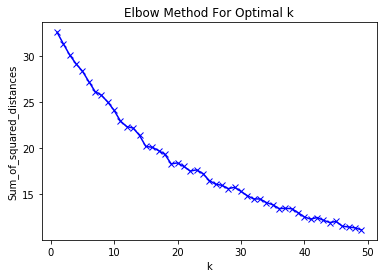

In [32]:
Sum_of_squared_distances = []
cities_grouped=cities_matrix.groupby('Neighbor').mean().reset_index()
cities_grouped_clustering = cities_grouped.drop('Neighbor', 1)
ssd=dict()

K = range(1,50)
for k in K:
    km = KMeans(n_clusters=k,random_state=0,algorithm='full')
    km = km.fit(cities_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)
    ssd[k]=km.inertia_
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

We don't really see an "Elbow". We can see that the distance decrease more slowly when k increases, but no really Elbow.

We will try to find using the Silhouette Method what k maximize the distance between the clusters.

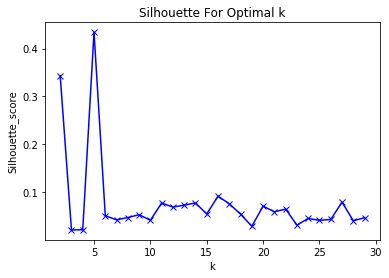

In [33]:
from sklearn.metrics import silhouette_samples, silhouette_score
X=cities_grouped_clustering

range_n_clusters = range(2,30)
silhouette_scores=dict()

for n_clusters in range_n_clusters:

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores[n_clusters]=silhouette_avg
    #print("For n_clusters =", n_clusters,
          #"The average silhouette_score is :", silhouette_avg)
df_sil = pd.DataFrame([{k: v for k, v in sorted(silhouette_scores.items(), key=lambda item: item[1],reverse=True)}]).T
df_sil.columns=['Silhouette_score']
df_sil['k']=df_sil.index
df_sil=df_sil.sort_values(by=['k'])

#Plot silhouette
plt.plot(df_sil.k,df_sil['Silhouette_score'], 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette_score')
plt.title('Silhouette For Optimal k')
plt.show()

We can see that k=3 and 4 have far better performance than other k. But looking at the Elbow Method, k 3/4 have a high inertia. So I will choose k=4, with has a lower inertia. By the way, that's quite a slow number for a recommander...only four choices?

In [34]:
km = KMeans(n_clusters=4,random_state=0,algorithm='full')
km = km.fit(cities_grouped_clustering)

<h4> b - DBscan </h4>

I will try to use DBscan in order to find clusters.

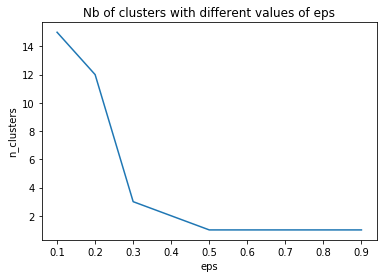

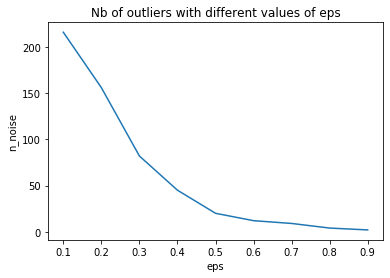

In [35]:
eps_val=np.arange(0.1,1,0.1)
n_clusters=[]
n_noise=[]

for i in eps_val:

    db = DBSCAN(eps=i, min_samples=2).fit(cities_grouped_clustering)
    labels = db.labels_

    n_clusters.append( len(set(labels)) - (1 if -1 in labels else 0))
    n_noise.append(list(labels).count(-1))

plt.plot(eps_val,n_clusters)
plt.xlabel('eps')
plt.ylabel('n_clusters')
plt.title('Nb of clusters with different values of eps')
plt.show()

plt.plot(eps_val,n_noise)
plt.xlabel('eps')
plt.ylabel('n_noise')
plt.title('Nb of outliers with different values of eps')
plt.show()
plt.show()

Seems like 0.3 is the best fit. With it, I obtain 3 clusters.

In [36]:
db = DBSCAN(eps=0.3, min_samples=2).fit(cities_grouped_clustering)
labels = db.labels_

n_clusters= len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print('I obtain ',n_clusters,' clusters, and ',n_noise,' outliers.')
print(round(n_noise/len(labels)*100,2),"% of neighborhoods are outliers.")

I obtain  3  clusters, and  82  outliers.
31.06 % of neighborhoods are outliers.


So once again, with the high number of outliers,and a small number of clusters, the result is not very satisfying.

I will then plot the clusters.

In [37]:
X=cities_merged
X['km Cluster Labels']=km.labels_
X['db Cluster Labels']=db.labels_
X.head()


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,City,Latitude,Longitude,full_adress,full_name,km Cluster Labels,db Cluster Labels
0,Amber Road,Chinese Restaurant,Shopping Mall,Café,Hotel,Indian Restaurant,Singapore,1.300993,103.901415,"Singapore, Amber Road",Singapore Amber Road,0,0
1,Ang Mo Kio,Coffee Shop,Food Court,Dessert Shop,Japanese Restaurant,Bubble Tea Shop,Singapore,1.370073,103.849516,"Singapore, Ang Mo Kio",Singapore Ang Mo Kio,0,0
2,Braddell,Food Court,Chinese Restaurant,Noodle House,Café,Asian Restaurant,Singapore,1.340071,103.846758,"Singapore, Braddell",Singapore Braddell,0,0
3,Bukit Panjang,Fast Food Restaurant,Coffee Shop,Sushi Restaurant,Asian Restaurant,Gym,Singapore,1.378629,103.762136,"Singapore, Bukit Panjang",Singapore Bukit Panjang,0,0
4,Bukit Timah,Trail,Mountain,Rest Area,Scenic Lookout,Zoo Exhibit,Singapore,1.354690,103.776372,"Singapore, Bukit Timah",Singapore Bukit Timah,0,-1


<b> Plot Singapore </b>

In [38]:
address = 'Singapore'

geolocator = Nominatim(user_agent="singapore")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_singapore = folium.Map(location=[latitude, longitude], zoom_start=11)

In [39]:
max_k=max(len(X['db Cluster Labels'].unique()),len(X['db Cluster Labels'].unique()))
x = np.arange(max_k+1)
ys = [i + x + (i*x)**2 for i in range(max_k+1)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow=['green','blue','red','yellow','pink','white','purple','black','lightblue']


# add markers km to the map
markers_colors = []
for lat, lon, poi, cluster in zip(X['Latitude'], X['Longitude'], X['Neighborhood'], X['km Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    cluster=int(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_singapore)
       
# add markers DB to the map
markers_colors = []
for lat, lon, poi, cluster in zip(X['Latitude'], X['Longitude'], X['Neighborhood'], X['km Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    cluster=int(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster+1],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_singapore)
       
map_singapore

<b> Plot New-York</b>

In [40]:
address = 'New York'

geolocator = Nominatim(user_agent="NY")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_NY = folium.Map(location=[latitude, longitude], zoom_start=11)

In [41]:
# add markers km to the map
markers_colors = []
for lat, lon, poi, cluster in zip(X['Latitude'], X['Longitude'], X['Neighborhood'], X['km Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    cluster=int(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_NY)
       
# add markers DB to the map
markers_colors = []
for lat, lon, poi, cluster in zip(X['Latitude'], X['Longitude'], X['Neighborhood'], X['km Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    cluster=int(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster+1],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_NY)
       
map_NY

We can see that DBscan and kmeans quite have the same models. In fact, the model is not good: it's one large cluster, then others very small/outliers.

In [42]:
cities_merged['City'].value_counts()

New York     172
Singapore     72
Paris         20
Name: City, dtype: int64

In [43]:
cities_merged['km Cluster Labels'].value_counts()

0    133
2    119
1     11
3      1
Name: km Cluster Labels, dtype: int64

In [44]:
cities_merged['db Cluster Labels'].value_counts()

 0    178
-1     82
 2      2
 1      2
Name: db Cluster Labels, dtype: int64

Is it surprising? Not really. If I look at my one-hot-encoding matrix, I can see that I have a problem of dimensionnality:

In [45]:
print('I have ',cities_matrix.shape[0],' and ',cities_matrix.shape[1]-1,' features.')

I have  264  and  389  features.


That's not good! I will do some feature engineering in order to decrease that.

<h3>2 - feature engineering </h3>

Let's have a look at how many type of venues are restaurants.

In [46]:
cities_matrix.columns[1:]
resto = lambda x: 'Restaurant' in x
restaurants=cities_matrix.columns[list(map(resto, cities_matrix.columns))]
print(round(len(restaurants)/len(cities_matrix.columns[1:])*100,2),'% of the types of venues are restaurants')

21.34 % of the types of venues are restaurants


In [47]:
cities_matrix.columns[1:]
bar = lambda x: 'Bar' in x
bars=cities_matrix.columns[list(map(bar, cities_matrix.columns))]
print(round(len(bars)/len(cities_matrix.columns[1:])*100,2),'% of the types of venues are bars')

3.6 % of the types of venues are bars


In [48]:
cities_matrix.columns[1:]
shop = lambda x: 'Shop' in x
shops=cities_matrix.columns[list(map(shop, cities_matrix.columns))]
print(round(len(shops)/len(cities_matrix.columns[1:])*100,2),'% of the types of venues are shops')

10.03 % of the types of venues are shops


So I will try to create new categories, in order to reduce the dimensionality.

In [50]:
dic_categories=dict()

def create_categories(list_values,new_name,dico=dic_categories,cols=cities_matrix.columns,list_names=cities_matrix.columns[1:]):
    empty_list=[]
    for val in list_values:
        empty_list.append(list_names[list(map(lambda x: val in x, list_names))])
        
    dico[new_name]=[item for sublist in empty_list for item in sublist]
    return dico

Now, I will replace precise categories names such as "Chinese Restaurant" by a meta-category name such as "Restaurants". I will create new categories such as "Nature", "Bars", "Services" etc...

In [51]:
dic_categories=dict()
dic_categories=create_categories(['Restaurant','Diner','Noodle','Buffet','Joint','Cafeteria','Brasserie','Breakfast','Churrascaria','Place','Steakhouse','Fried','Food','Creperie','Snack'],'Restaurants')
dic_categories=create_categories(['Shop','Store','Supermarket','Bookstore','Shopping','Boutique','Dealership','Mall'],'Shops')
dic_categories=create_categories(['Grocery','Bakery','Butcher','Brewery'],'Food Shops')
dic_categories=create_categories(['Bar','Pub','Coffee','Bistrot','Bistro','Café','Gastropub','Deli / Bodega'],'Bars')
dic_categories=create_categories(['Pedestrian','Lookout','Lake','Outdoors','Garden','Harbor / Marina','Waterfront','Outdoors','Nature','Mountain','Beach'],'Nature, gardens and walks')
dic_categories=create_categories(['Cultural','Castle','Monument','Canal','Concert','Sculpture','Museum','Art','Historic','Memorial'],'Culture')
dic_categories=create_categories(['Sport','Gym','Sports','Racetrack','Skating','Track','Course','Surf','Court','Bowling','Trail','Field','Tennis','Soccer','Climbing','Studio'],'Sport')
dic_categories=create_categories(['Market'],'Market')
dic_categories=create_categories(['Nightlife','Club'],'Nightlife')
dic_categories=create_categories(['Entertainment','Casino','Arcade','Recreation','Multiplex','Music','Theater','Gaming','Park','Play','Exhibit','Stadium'],'Entertainment')
dic_categories=create_categories(['School','College'],'Schools')
dic_categories=create_categories(['Service','Bank'],'Services')
dic_categories=create_categories(['Hospital','Pharmacy'],'Medical')
dic_categories=create_categories(['Airport ','Train','Taxi','Bus','Boat'],'Transportation')
dic_categories=create_categories(['Airport Terminal',
 'Bath House',
 'Bike Rental / Bike Share',
 'Border Crossing',
 'Bridge',
 'Building',
 'Casino',
 'Church',
 'Community Center',
 'Construction & Landscaping',
 'Coworking Space',
 'Daycare',
 'Distillery',
 'Dog Run',
 'Drugstore',
 'Dry Cleaner',
 'Elementary School',
 'Event Space',
 'Farm',
 'Gas Station',
 'Government Building',
 'Hostel',
 'Hotel',
 'Hotel Pool',
 'Insurance Office',
 'Intersection',
 'Laundromat',
 'Lawyer',
 'Library',
 'Light Rail Station',
 'Lighthouse',
 'Lounge',
 'Medical Center',
 'Metro Station',
 'Mosque',
 'Motel',
 'Moving Target',
 'Nail Salon',
 'Neighborhood',
 'Nightclub',
 'Office',
 'Other Great Outdoors',
 'Pier',
 'Platform',
 'Plaza',
 'Pool',
 'Pool Hall',
 'Post Office',
 'Rental Car Location',
 'Residential Building (Apartment / Condo)',
 'Rest Area',
 'River',
 'Roof Deck',
 'Spa',
 'Speakeasy',
 'Storage Facility',
 'Tea Room',
 'Tourist Information Center',
 'Travel Lounge',
 'Waste Facility',
 'Weight Loss Center'],'Others')

I will replace the venue category by the meta category if it exists.

In [52]:
venues=cities_venues['Venue Category']
new_vals=[]
others=[]

for val in venues:
    if val in [item for sublist in dic_categories.values() for item in sublist]:
        test=0
        for key, value in dic_categories.items():
            #print(val)
            #print(key,val in value)
            if  val in value and test==0:
                new_vals.append(key)
                test=1
    else:
        new_vals.append(val)
        others.append(val)
        
if len(venues)==len(new_vals):#Check if I have the same number of items
    print('Ok')
else:
    print("Problem, length venues is ",len(venues)," and length new_vals is ",len(new_vals),', please check. (Difference: ',len(venues)-len(new_vals),')')

Ok


In [53]:
print('Now I have ',len(set(new_vals)),' categories vs ',len(cities_venues['Venue Category'].unique()),'before.')

Now I have  16  categories vs  389 before.


I will then try to redo the clustering.

In [54]:
cat_venues=cities_venues
cat_venues['Venue Category']=new_vals
cat_matrix=create_neighborood_matrix(cat_venues)
cat_most_common=create_most_common_venues(cities_matrix=cat_matrix, num_top_venues=5)

In [55]:
cat_most_common.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Amber Road,Restaurants,Shops,Bars,Others,Sport
1,Ang Mo Kio,Restaurants,Shops,Sport,Services,Medical
2,Braddell,Restaurants,Bars,Shops,Food Shops,Others
3,Bukit Panjang,Restaurants,Shops,Bars,Sport,Transportation
4,Bukit Timah,Sport,"Nature, gardens and walks",Others,Transportation,Shops


Now I will try kmeans again.

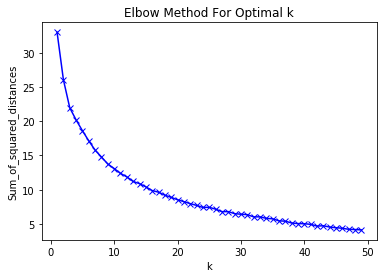

In [56]:
Sum_of_squared_distances = []
cat_grouped=cat_matrix.groupby('Neighbor').mean().reset_index()
cat_grouped_clustering = cat_grouped.drop('Neighbor', 1)
ssd=dict()

K = range(1,50)
for k in K:
    km_cat = KMeans(n_clusters=k,random_state=0)
    km_cat = km_cat.fit(cat_grouped_clustering)
    Sum_of_squared_distances.append(km_cat.inertia_)
    ssd[k]=km.inertia_
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The Elbow is still not very clear, but it looks better!

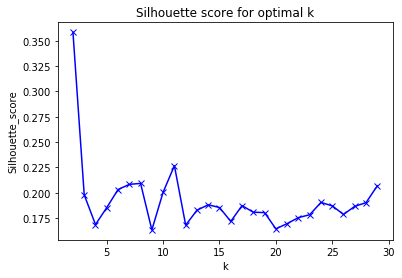

In [57]:
X=cat_grouped_clustering

range_n_clusters = range(2,30)
silhouette_scores=dict()

for n_clusters in range_n_clusters:

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores[n_clusters]=silhouette_avg
    #print("For n_clusters =", n_clusters,
          #"The average silhouette_score is :", silhouette_avg)
df_sil = pd.DataFrame([{k: v for k, v in sorted(silhouette_scores.items(), key=lambda item: item[1],reverse=True)}]).T
df_sil.columns=['Silhouette_score']
df_sil['k']=df_sil.index
df_sil=df_sil.sort_values(by=['k'])

plt.plot(df_sil.k,df_sil['Silhouette_score'], 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette_score')
plt.title('Silhouette score for optimal k')
plt.show()

The optimum k is 9.

In [58]:
km_cat = KMeans(n_clusters=9,random_state=0,algorithm='full')
km_cat = km_cat.fit(cat_grouped_clustering)

Then DBSCAN.

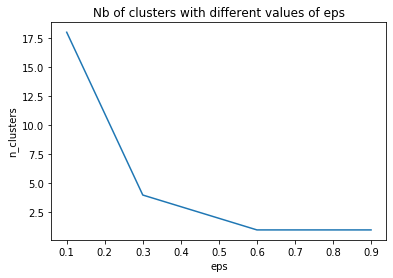

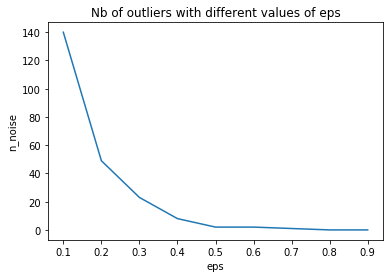

In [59]:
eps_val=np.arange(0.1,1,0.1)
n_clusters=[]
n_noise=[]

for i in eps_val:

    db = DBSCAN(eps=i, min_samples=2).fit(cat_grouped_clustering)
    labels = db.labels_

    n_clusters.append( len(set(labels)) - (1 if -1 in labels else 0))
    n_noise.append(list(labels).count(-1))

plt.plot(eps_val,n_clusters)
plt.xlabel('eps')
plt.ylabel('n_clusters')
plt.title('Nb of clusters with different values of eps')
plt.show()

plt.plot(eps_val,n_noise)
plt.xlabel('eps')
plt.ylabel('n_noise')
plt.title('Nb of outliers with different values of eps')
plt.show()
plt.show()

eps=0.3 seems a good fit!

In [60]:
db_cat = DBSCAN(eps=0.3, min_samples=2).fit(cat_grouped_clustering)
labels = db_cat.labels_

n_clusters= len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print('I obtain ',n_clusters,' clusters, and ',n_noise,' outliers.')
print(round(n_noise/len(labels)*100,2),"% of neighborhoods are outliers.")

I obtain  4  clusters, and  23  outliers.
8.71 % of neighborhoods are outliers.


That's better! 

I will plot the clusters.

In [197]:
cat_merged=cat_most_common.merge(cities,on="Neighborhood")
cat_merged=cat_merged.drop_duplicates()
X=cat_merged
X['km Cluster Labels']=km_cat.labels_
X['db Cluster Labels']=db_cat.labels_
X.head()


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,City,Latitude,Longitude,full_adress,full_name,km Cluster Labels,db Cluster Labels
0,Amber Road,Restaurants,Shops,Bars,Others,Sport,Singapore,1.300993,103.901415,"Singapore, Amber Road",Singapore Amber Road,0,0
1,Ang Mo Kio,Restaurants,Shops,Sport,Services,Medical,Singapore,1.370073,103.849516,"Singapore, Ang Mo Kio",Singapore Ang Mo Kio,0,0
2,Braddell,Restaurants,Bars,Shops,Food Shops,Others,Singapore,1.340071,103.846758,"Singapore, Braddell",Singapore Braddell,3,0
3,Bukit Panjang,Restaurants,Shops,Bars,Sport,Transportation,Singapore,1.378629,103.762136,"Singapore, Bukit Panjang",Singapore Bukit Panjang,3,0
4,Bukit Timah,Sport,"Nature, gardens and walks",Others,Transportation,Shops,Singapore,1.354690,103.776372,"Singapore, Bukit Timah",Singapore Bukit Timah,4,1


In [201]:
address = 'Singapore'

geolocator = Nominatim(user_agent="singapore")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_singapore = folium.Map(location=[latitude, longitude], zoom_start=11)

markers_colors = []
for lat, lon, poi, cluster in zip(X['Latitude'], X['Longitude'], X['Neighborhood'], X['km Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    cluster=int(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_singapore)
       

       
map_singapore



In [200]:
address = 'New York'

geolocator = Nominatim(user_agent="NY")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_NY = folium.Map(location=[latitude, longitude], zoom_start=11)

markers_colors = []
for lat, lon, poi, cluster in zip(X['Latitude'], X['Longitude'], X['Neighborhood'], X['km Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    cluster=int(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_NY)
       

       
map_NY



I have a look at the number of values in each clusters:

In [70]:
cat_merged['km Cluster Labels'].value_counts()

0    104
3     68
7     29
5     25
4     10
2      9
1      7
8      6
6      6
Name: km Cluster Labels, dtype: int64

In [71]:
cat_merged['db Cluster Labels'].value_counts()

 0    234
-1     23
 1      3
 3      2
 2      2
Name: db Cluster Labels, dtype: int64

<h2>3 - The choice </h2>

I have decided to work with kmeans, with the meta categories. Two reason for this choice:
    - I have more clusters, meaning my recommender will be more specialized
    - I don't have outliers. Outliers will be a problem with my recommender. What if the initial place is an outlier?
    - Looking at the values in my cluster, dbscan has in fact one big cluster and the other ones are very small. Kmeans have more balanced clusters.

In [79]:
def explore_cluster(df,cluster_number,type_cluster='km'):
    if type_cluster=='km':
        var='km Cluster Labels'
    sub=df[df[var]==cluster_number]
    ven = lambda x: 'Venue' in x
    cols=sub.columns[list(map(ven, sub.columns))]
    flat_list=sub[cols].to_numpy().flatten()
    unique, counts = np.unique(flat_list, return_counts=True)
    x=dict(zip(unique, counts))
    sorted_x = pd.DataFrame([{k: v for k, v in sorted(x.items(), key=lambda item: item[1],reverse=True)}]).T
    sorted_x.columns=['Cluster number '+str(cluster_number)+' nb cities:'+str(sub.shape[0])]
    sorted_x['Normalized']=round(sorted_x['Cluster number '+str(cluster_number)+' nb cities:'+str(sub.shape[0])]/sub.shape[0],2)
    return sorted_x.head(10)

Let's have a look at the biggest clusters:

In [80]:
explore_cluster(cat_merged,3)


,Cluster number 3 nb cities:68,Normalized
Restaurants,68,1.00
Shops,65,0.96
Bars,46,0.68
Others,34,0.50
Transportation,33,0.49
Sport,31,0.46
Food Shops,20,0.29
Services,20,0.29
Medical,8,0.12
Entertainment,7,0.10


In [81]:
explore_cluster(cat_merged,7)

,Cluster number 7 nb cities:29,Normalized
Restaurants,29,1.00
Bars,23,0.79
Shops,18,0.62
Sport,17,0.59
Others,16,0.55
Transportation,13,0.45
Entertainment,8,0.28
Culture,6,0.21
"Nature, gardens and walks",4,0.14
Services,4,0.14


In [82]:
explore_cluster(cat_merged,5)

,Cluster number 5 nb cities:25,Normalized
Shops,25,1.00
Restaurants,19,0.76
Transportation,19,0.76
Sport,17,0.68
Others,10,0.40
Services,10,0.40
Bars,8,0.32
Entertainment,6,0.24
Medical,4,0.16
Schools,3,0.12


In [83]:
explore_cluster(cat_merged,4)

,Cluster number 4 nb cities:10,Normalized
Sport,10,1.0
Entertainment,7,0.7
Shops,7,0.7
Transportation,7,0.7
"Nature, gardens and walks",5,0.5
Restaurants,5,0.5
Others,4,0.4
Bars,2,0.2
Culture,1,0.1
Food Shops,1,0.1


We will plot these values.

In [90]:
all_indexes=[]
for i in [3,5,7,4]:
    all_indexes.append(explore_cluster(cat_merged,i).index)
    
all_indexes=set([item for sublist in all_indexes for item in sublist])

In [96]:
df_all=pd.DataFrame()
for i in [3,5,7,4]:
    sub=explore_cluster(cat_merged,i)
    sub['Category']=sub.index
    sub['cluster']=i
    df_all=df_all.append(sub[['Category','Normalized','cluster']])
    
df_grouped=df_all.groupby(['Category','cluster']).sum().reset_index()

In [101]:
df_grouped.head()

,Category,cluster,Normalized
0,Bars,3,0.68
1,Bars,4,0.20
2,Bars,5,0.32
3,Bars,7,0.79
4,Culture,4,0.10


<Figure size 720x1440 with 0 Axes>

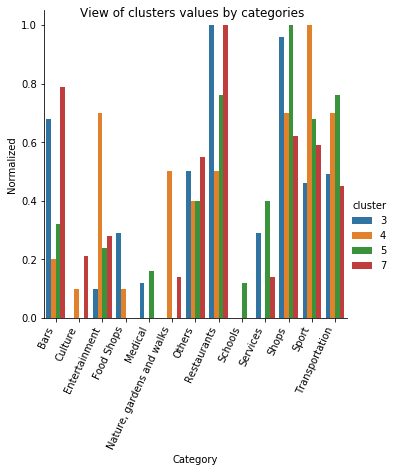

In [116]:
import seaborn as sns
plt.figure(figsize=(10,20))
g = sns.catplot(x="Category", y="Normalized",hue='cluster',data=df_grouped, kind="bar")
g.set_xticklabels(rotation=65, horizontalalignment='right')
g.fig.suptitle('View of clusters values by categories')
plt.show();

<h2>Step 4: Create the recommender</h2>

As I have decreased the precision of my recommender with meta categories, I have decided to add one step in order to improve the decision.

Here are the steps:
    - First, the user choose a feature he absolutly wants.
    - Then he enters the neighborhood he likes
    - And the targeted city
    - The answer is a neighborhood in the targeted city, within the same cluster than the initial target, with the feature he absolutly wants (if exists in the cluster).

In [148]:

#Ask informations to user
feature=input('Please choose a feature than you like.')
initial=input('Please choose a neighborood that you like (format city, Neighborood)')
target=input('Please choose the city where you want to move')

Please choose a feature than you like.Pizza Place
Please choose a neighborood that you like (format city, Neighborood)Singapore, Bukit Panjang
Please choose the city where you want to moveNew York


In [202]:
c=lambda x: x.split(',')[0]
cat_merged['city']=cat_merged.full_adress.apply(c)#Add city to dataframe

#Obtain cluster number
num_clust=cat_merged[cat_merged.full_adress==initial]['km Cluster Labels']

filt_df=cat_merged[cat_merged['km Cluster Labels']==num_clust.item()]#Obtain cluster number

#Filter rows from the dataset with precise categories within the same cluster
filt_precise=cities_merged[cities_merged.full_adress.isin(filt_df.full_adress)]
filt_precise=filt_precise[filt_precise.City==target]

m=filt_precise.isin([feature]).index.tolist()

if len(m)==0:
    print("Sorry, couldn't find a neighborood with",feature,'. But here is the list of neighborood in',target,'similar to the one that you enjoy.')
    
else:
    print("Here the places similar to the neighborood that you love, in",target,"and with a",feature,'!')
    filt_precise=filt_precise[filt_precise.index.isin(m)]

filt_precise.full_adress


Here the places similar to the neighborood that you love, in New York and with a Pizza Place !


66                  New York,Annadale
72                   New York,Astoria
78                   New York,Bayside
79             New York,Bayside Hills
81              New York,Bedford Park
92                 New York,Bronxdale
93                  New York,Bruckner
108             New York,Dongan Hills
122             New York,Far Rockaway
125                 New York,Flushing
126         New York,Flushing Heights
129             New York,Forest Hills
139              New York,Great Kills
145                New York,Hillcrest
149             New York,Howard Beach
153          New York,Jackson Heights
158        New York,Kew Gardens Hills
163                New York,Laurelton
183              New York,Murray Hill
186                 New York,New Dorp
187            New York,New Hyde Park
192                  New York,Norwood
193          New York,Oakland Gardens
196              New York,Old Astoria
198                New York,Olinville
207            New York,Port Richmond
208         

In [195]:
X=filt_precise
address = target

geolocator = Nominatim(user_agent="target")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

my_map = folium.Map(location=[latitude, longitude], zoom_start=11)

markers_colors = []
for lat, lon, poi,most1,most2,most3,most4,most5 in zip(X['Latitude'], X['Longitude'], X['Neighborhood'],X['1st Most Common Venue'],X['2nd Most Common Venue'],X['3rd Most Common Venue'],X['4th Most Common Venue'],X['5th Most Common Venue']):
    text='<b>'+str(poi)+'</b><br>'+str(most1)+'<br>'+str(most2)+'<br>'+str(most3)+'<br>'+str(most4)+'<br>'+str(most5)
    label = folium.Popup(text,parse_html=True)

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        fill=True,
        fill_color='green',
        fill_opacity=0.7).add_to(my_map)
       

       
my_map